# Imports

In [46]:
# Imports
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import os
import pywt

In [47]:
from IPython.display import clear_output

# Getting csv files

In [48]:
# Geting csv files
list_of_files = os.listdir("./")
csv_files = []

for _file in list_of_files:
    if _file.endswith(".csv"):
        csv_files.append(_file)

csv_files

['5_When_rebuilding.csv',
 '1_After_reconstruction.csv',
 '1_When_rebuilding.csv',
 '2_Before_renovation.csv',
 '6_After_reconstruction.csv',
 '2_When_rebuilding.csv',
 '4_Before_renovation.csv',
 '5_After_reconstruction.csv',
 '3_When_rebuilding.csv',
 '3_After_reconstruction.csv',
 '6_Before_renovation.csv',
 '4_After_reconstruction.csv',
 '1_Before_renovation.csv',
 '3_Before_renovation.csv',
 '6_When_rebuilding.csv',
 '2_After_reconstruction.csv',
 '5_Before_renovation.csv',
 '4_When_rebuilding.csv']

# Functions

In [49]:
def slice_signal_by_10_seconds(signal, sampling_rate):
    # Calculate the number of samples corresponding to 10 seconds
    ten_sec_samples = int(10 * sampling_rate)
    
    # Slice the signal into chunks of 10 seconds
    signal_chunks = [signal[i:i + ten_sec_samples] for i in range(0, len(signal), ten_sec_samples)]
    
    return signal_chunks

In [50]:
def extract_train_out_signal_chunks(signal, sampling_rate):
    '''
    Returns: The first 10-second signal and last 30-second signal which
                sliced by 10 seconds
    '''
    # Calculate the number of samples corresponding to 10 seconds
    ten_sec_samples = int(10 * sampling_rate)
    
    # Calculate the number of samples corresponding to 30 seconds
    thirty_sec_samples = int(30 * sampling_rate)
    
    # Get the first 10 seconds of the signal
    first_10_sec = signal[:ten_sec_samples]
    
    # Get the last 30 seconds of the signal
    last_30_sec = signal[-thirty_sec_samples:]
    
    # Split the last 30 seconds into chunks of 10 seconds
    chunks_last_30_sec = slice_signal_by_10_seconds(last_30_sec, sampling_rate)
    
    return first_10_sec, chunks_last_30_sec

In [51]:
def dir_creator(csv_file_name):
    '''
    Creating directoies for each column of csv files
        to save heatmaps into them
    '''
    sensor_number = csv_file_name.split('_')[0]
    file_name = csv_file_name.split('.')[0]

    # Define the sensor directory name
    sensor_dir = f"sensor_{sensor_number}"

    if not os.path.exists(sensor_dir):
        os.mkdir(sensor_dir)
    
    # Change directory to the sensor directory
    os.chdir(sensor_dir)
    
    # Create the main directory for the current file
    if not os.path.exists(file_name):
        os.mkdir(file_name)
        os.mkdir(f"{file_name}/train_out")
        os.mkdir(f"{file_name}/train_in")

    # Change back to the original directory
    os.chdir("..")

In [52]:
def save_heatmap(csv_file_name, column, counter, train_status):
    '''
    Saving plots in png format in their specific path
    '''
    no_ext_csv_file_name = csv_file_name.split('.')[0]
    sensor_number = csv_file_name.split('_')[0]
    sensor_dir = f"sensor_{sensor_number}"

    # Save the plot with no padding or extra space
    plt.axis('off')
    path = f"{sensor_dir}/{no_ext_csv_file_name}/{train_status}/{sensor_number}_{no_ext_csv_file_name}_{column}_{counter}.png"
    plt.savefig(path , bbox_inches='tight', pad_inches=0)
    plt.close()

In [53]:
def remove_five_zeros(arr):
    """Remove sequences of 5 successive zeros from an array."""
    result = []
    zero_count = 0

    for i in range(len(arr)):
        if arr[i] == 0:
            zero_count += 1
        else:
            if zero_count == 5:
                result = result[:-5]  # Remove the last 5 zeros from the result
            zero_count = 0
            result.append(arr[i])
        
        # If we've reached the end and have exactly 5 zeros at the end
        if i == len(arr) - 1 and zero_count == 5:
            result = result[:-5]
    
    return np.array(result)

In [54]:
def plot_cwt(coefficients_10s):
    """
    Plots a one-dimensional signal.

    Parameters:
    - Coefficients of CWT transformation.
    """
    # Desired size in pixels
    width_px = 200
    height_px = 200

    # DPI (dots per inch)
    dpi = 100

    # Convert to inches
    width_in = width_px / dpi
    height_in = height_px / dpi

    # Plot the CWT (10 seconds)
    plt.figure(figsize=(width_in, height_in), dpi=dpi)
    # plt.figure(figsize=(12, 8))
    plt.imshow(np.abs(coefficients_10s), extent=[0, 10, 1, 128], cmap='jet', aspect='auto',
            vmax=np.percentile(np.abs(coefficients_10s), 99))

In [55]:
def plot_signal(signal, sampling_rate=825.8, title="Signal Plot", xlabel="Time", ylabel="Amplitude"):
    """
    Plots a one-dimensional signal.

    Parameters:
    - signal: List or array-like, the 1D signal to plot.
    - sampling_rate: Sampling rate of the signal (default is 825.8).
    - title: Title of the plot (default is "Signal Plot").
    - xlabel: Label for the x-axis (default is "Time").
    - ylabel: Label for the y-axis (default is "Amplitude").
    """
    # Create time vector based on the length of the signal and the sampling rate
    time = [i / sampling_rate for i in range(len(signal))]
    
    # Plot the signal
    plt.figure(figsize=(10, 5))
    plt.plot(time, signal, label='Signal', color='b', linewidth=1.5)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.legend()
    plt.show()

In [56]:
# Reading files
df = pd.read_csv("./1_After_reconstruction.csv")

# Nan to zero
df = df.fillna(0)
    
# Loading each column of df into dict
columns_dict = {}
for col in df.columns:
    columns_dict[col] = df[col].to_numpy()
# Removing first incremental column
columns_dict.pop('Unnamed: 0')

array([    0,     1,     2, ..., 78430, 78431, 78432])

In [57]:
# Initializing fs
fs=825.8

Signal length in seconds: 50.99418745458949 (s)


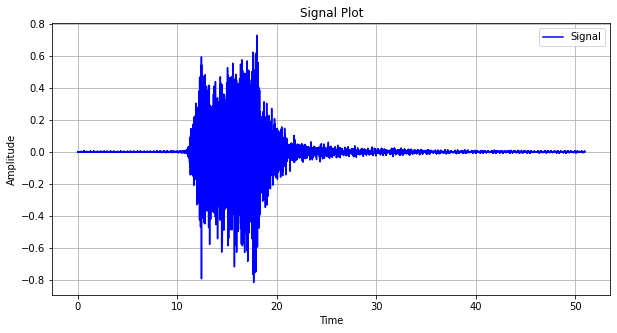

In [58]:
# Removing 5 successive zeros
signal = remove_five_zeros(columns_dict['0'])

# Getting the length of signal in seconds
print(f"Signal length in seconds: {len(signal)/fs} (s)")
plot_signal(signal)

In [59]:
def zero_mean_normalization(signal):
    """
    Normalizes a one-dimensional signal to have zero mean normalization.

    Gets:
    - One Dimensional signal

    Returns:
    - Zero mean normalized signal
    """
    signal = np.array(signal)  
    mean = np.mean(signal)     
    std = np.std(signal)
    
    # Zero-mean normalization: (signal - mean) / std
    normalized_signal = (signal - mean) / std
    
    return normalized_signal

In [60]:
def continuous_wavelet_transform(signal, wavelet='cmor1.5-1.0'):
    """
    Perform Continuous Wavelet Transform on a given signal with specified frequency range.
    return: (coefficients, frequencies) tuple
             - coefficients: 2D array of CWT coefficients
             - frequencies: Corresponding frequencies for the scales
    """
    # Continuous Wavelet Transform (CWT)
    scales = np.arange(1, 128)

    # Perform CWT on the signal
    coefficients, frequencies = pywt.cwt(signal, scales, wavelet)
        
    return coefficients, frequencies

# Creating heatmaps of CWT signals

In [61]:
wavelet_name='cmor1.5-1.0'

In [62]:
information = {}
number_of_each_class_images = {
    "After" : 0,
    "When": 0,
    "Before": 0
}

In [63]:
len(columns_dict[col]) // fs - 40

54.0

In [ ]:
# Reading and processing csv files
for csv_file in csv_files:
    # Reading files
    df = pd.read_csv(csv_file)

    # Nan to zero
    df = df.fillna(0)
    
    # Loading each column of df into dict
    columns_dict = {}
    for col in df.columns:
        columns_dict[col] = zero_mean_normalization(df[col].to_numpy())
    # Removing first incremental column
    columns_dict.pop('Unnamed: 0') 

    # Creating dirs
    dir_creator(csv_file)

    information[csv_file] = {}

    for col in columns_dict.keys():
        clear_output(wait=True)
        heatmaps_counter = 1
        information[csv_file][col] = {}
        print(f"Processing: {csv_file}:\t Column {col}")

        # Removing 5 successive zeros
        print("\t\t. ", end="")
        print("Removing 5 successive zeros")
        columns_dict[col] = remove_five_zeros(columns_dict[col])
        
        # Printing the amount of images when train is in (40 seconds is when train is out)
        print("\t\t. ", end="")
        print(f"Number of images when train is in: { int( (len(columns_dict[col]) // fs - 40) // 10 ) }")
        
        # Recording information
        information[csv_file][col][f"Images count, train in"] = int( (len(columns_dict[col]) // fs - 40) // 10 )
        information[csv_file][col][f"Images count, train out"] = 4
        information[csv_file][col][f"Whole signal length in seconds"] = int(len(columns_dict[col]) // fs)
        class_name = csv_file.split('_')[1]
        number_of_each_class_images[class_name] += 1

        # handling train out part
        first_10, last_30 = extract_train_out_signal_chunks(columns_dict[col], fs)
        
        # Calculating CWT transform and heatmap creation
        print("\t\t. ", end="")
        print("Calculating CWT transform and heatmap creation")
        coefficients, frequencies = continuous_wavelet_transform(first_10, wavelet_name)
        plot_cwt(coefficients)
        save_heatmap(csv_file, col, heatmaps_counter, "train_out")
        heatmaps_counter += 1
        
        for sig_chunk in last_30:
            coefficients, frequencies = continuous_wavelet_transform(sig_chunk, wavelet_name)
            plot_cwt(coefficients)
            save_heatmap(csv_file, col, heatmaps_counter, "train_out")
            heatmaps_counter += 1
        
        # handling train in part
        train_in_sig_chunks = slice_signal_by_10_seconds(columns_dict[col][int(10*fs):int(-30*fs)], fs)
        for sig_chunk in train_in_sig_chunks:
            coefficients, frequencies = continuous_wavelet_transform(sig_chunk, wavelet_name)
            plot_cwt(coefficients)
            save_heatmap(csv_file, col, heatmaps_counter, "train_in")
            heatmaps_counter += 1